In [94]:
import pandas as pd
import pandas as pd
import os
import numpy as np
import re
from googlesearch import search
import requests
from bs4 import BeautifulSoup
import zipfile
import time
import pandas as pd
import glob
import os
import pandas as pd
import re
from fuzzywuzzy import process
import geopandas as gpd
from fuzzywuzzy import fuzz
from shapely.geometry import Point

In [ ]:
sample_string = "PRELIM INFO FROM FAA OPS: NASHVILLE, TN/UAS INCIDENT/1205C/NASHVILLE APCH ADVISED CESSNA C650, REPORTED A WHITE UAS FROM THE 10 O'CLOCK POSITION WHILE NE BOUND AT 4,000 FEET 10 SE NASHVILLE. NO EVASIVE ACTION REPORTED. NASHVILLE ARPT PD NOTIFIED. WOC 7-3333 DJ/ER"

zip_file_path_airport = "all-airport-data.xlsx.zip"
xlsx_file_name_airport = "all-airport-data.xlsx"

with zipfile.ZipFile(zip_file_path_airport) as z:
    with z.open(xlsx_file_name_airport) as f:
        airport_codes_2 = pd.read_excel(f)

airport_codes_2.head()

''''
Algo 1: Code extracting
'''

extracted_code = ""
x = sample_string
splitted_x = x.split()
punc = '''!()-[]{};:'"\,<>.,/?@#$%^&*_~'''
list_codes = list(airport_codes_2["Loc Id"])


# Removing punctuations in string
# Using loop + punctuation string
index = 0
for word in splitted_x:
    for letter in word:
        if letter in punc:
            word = word.replace(letter, "")
            splitted_x[index] = word
    index = index + 1
filtered_codes = list(set([i for i in splitted_x if len(i) == 3 and i not in ["FAA", "UAS", "OPS", "THE"]]))
for i in filtered_codes:
    if i in list_codes:
        extracted_code = i

''''
Algo 2: Code extracting w/ Fuzzy
'''

airport_trimmed = airport_codes_2[[
    "Loc Id", "Facility Type", "ARP Latitude DD", "ARP Longitude DD", "State Name", "County", "Name"]].rename(columns={
    "Loc Id": "faa_code",
    "ARP Latitude DD": "latitude",
    "ARP Longitude DD": "longitude",
    "State Name": "airport_state",
    "County": "airport_county",
    "Name": "Facility Name" 
})

def extract_facility(summary):
    match = re.search(r'([A-Z\s]+)\s+(TRACON|ATCT|ARTCC|APCH|TWR)\s+ADVISED', str(summary))
    return match.group(1).strip() if match else None

facility = extract_facility(sample_string)

# === Fuzzy Match Facility Name to Airport County or FAA Code Name ===

airport_names = airport_trimmed["Facility Name"].dropna().unique().tolist()

def fuzzy_match_airport_name(facility_name):
    if not facility_name:
        return None
    best_match, score = process.extractOne(facility_name.title(), airport_names, scorer=fuzz.token_set_ratio)
    print(f"[DEBUG] Matching '{facility_name}' → '{best_match}' (score: {score})")
    return best_match if score >= 85 else None

extracted_name = fuzzy_match_airport_name(facility)
extracted_code = list(airport_trimmed[airport_trimmed["Facility Name"] == extracted_name]["faa_code"])[0]
extracted_code

''''
Algo 3: Getting lat/long
'''

latitude = list(airport_trimmed[airport_trimmed["Facility Name"] == extracted_name]["latitude"])[0]
longitude = list(airport_trimmed[airport_trimmed["Facility Name"] == extracted_name]["longitude"])[0]
longitude, latitude

''''
Algo 4: Getting all the details
'''

def extract_direction(summary):
    match = re.search(r'\b(?:WHILE|DEPARTED|HEADED|NORTHBOUND|SOUTHBOUND|WESTBOUND|EASTBOUND)\s+([A-Z\- ]+BOUND)\b', summary)
    return match.group(1).strip() if match else np.nan

# === 2. Time
pattern1 = r'\b(\d{4}[A-Z])\b'
pattern2 = r'Date\/Time:\s+.*?(\d{4}[A-Z])'
pattern3 = r'\b(\d{1,2}:\d{2}:\d{2}\s?(?:AM|PM))\b'

time1 = re.search(pattern1, sample_string)
time2 = re.search(pattern2, sample_string)
time3 = re.search(pattern3, sample_string)

extracted_time = time1.group(1) if time1 else time2.group(1) if time2 else time3.group(1) if time3 else np.nan

# === 3. Authority Advised
authority_match = re.search(r'(?<=\/)([A-Z ]+)(?= ADVISED)', sample_string)
authority_advised = authority_match.group(1).strip() if authority_match else np.nan

# === 4. Route
route_match = re.search(r'(?<=, )([A-Z ,()]+ - [A-Z ,()]+)(?=,)', sample_string)
route = route_match.group(1).strip() if route_match else np.nan

# === 5. Location
def extract_location(summary):
    match = re.search(r'([0-9]+(?:\.\d+)?\s?(?:[A-Z]+)\s+(?:[A-Z().\- ]+))(?= AT| FEET| VCNTY|\.|,)', summary)
    if match:
        return match.group(1).strip()
    match2 = re.search(r'VCNTY\s+([A-Z().\- ]+)', summary)
    if match2:
        return "VCNTY " + match2.group(1).strip()
    return np.nan

location = extract_location(sample_string)

# === 6. Altitude
alt_match = re.search(r'(?<= )(AT [0-9,]+ FEET)(?= )', sample_string)
altitude = alt_match.group(1).strip() if alt_match else np.nan

# === Results
print("📍 Direction:", extract_direction(sample_string))
print("⏰ Time:", extracted_time)
print("🛑 Authority Advised:", authority_advised)
print("🛣️ Route:", route)
print("📌 Location:", location)
print("⬆️ Altitude:", altitude)

''''
Algo 5: Getting direction
'''

# === First Attempt ===
def extract_direction(summary):
    match = re.search(r'\b(?:WHILE|DEPARTED|HEADED|NORTHBOUND|SOUTHBOUND|WESTBOUND|EASTBOUND)\s+([A-Z\- ]+BOUND)\b', summary)
    return match.group(1).strip() if match else np.nan

# === Fallback (Robust) ===
def extract_direction_robust(summary):
    summary = summary.upper()

    match = re.search(r'\b(?:WHILE|HEADED|DEPARTED|FLYING)\s+([A-Z\-]+ BOUND)\b', summary)
    if match:
        return match.group(1).strip()

    match = re.search(r'\b([0-9]+(?:\.\d+)?)\s+(N|NE|E|SE|S|SW|W|NW)\s+OF\b', summary)
    if match:
        return match.group(2) + " BOUND"

    match = re.search(r'FINAL.*?RUNWAY\s+([0-9]{2})', summary)
    if match:
        heading = int(match.group(1)) * 10
        directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
        direction_idx = round(heading % 360 / 45) % 8
        return directions[direction_idx] + " BOUND"

    match = re.search(r'\b([0-9]+(?:\.\d+)?)\s+(N|NE|E|SE|S|SW|W|NW)\s+[A-Z\-]+', summary)
    if match:
        return match.group(2) + " BOUND"

    match = re.search(r'\b([NSEW]{1,2})\sBOUND\b', summary)
    if match:
        return match.group(1) + " BOUND"

    return np.nan

# === Two-Step Extraction ===
direction = extract_direction(sample_string)
if pd.isna(direction):
    direction = extract_direction_robust(sample_string)

print("Final Direction:", direction)

# === Primary extractor (simple pattern like "AT 4,000 FEET")
def extract_altitude_simple(summary):
    match = re.search(r'(?<= )(AT [0-9,]+ FEET)(?= )', summary)
    return match.group(1) if match else np.nan

# === Fallback robust extractor
def extract_altitude_robust(summary):
    if pd.isna(summary):
        return np.nan

    summary = summary.upper()

    # 1. Catch "BETWEEN X AND Y FEET" — take the max value
    match = re.search(r'BETWEEN\s+([0-9,]+)\s+AND\s+([0-9,]+)\s+FEET', summary)
    if match:
        return int(match.group(2).replace(",", ""))

    # 2. Catch "AT X FEET" or "ORBITING AT X FEET"
    match = re.search(r'AT\s+([0-9,]+)\s+FEET', summary)
    if match:
        return int(match.group(1).replace(",", ""))

    # 3. Catch general "X FEET" mention
    match = re.search(r'\b([0-9,]+)\s+FEET\b', summary)
    if match:
        return int(match.group(1).replace(",", ""))

    return np.nan

# === Two-pass extraction logic
primary_alt = extract_altitude_simple(sample_string)
if pd.isna(primary_alt):
    final_altitude = extract_altitude_robust(sample_string)
else:
    # Extract numeric part from "AT 4,000 FEET"
    match = re.search(r'([0-9,]+)', primary_alt)
    final_altitude = int(match.group(1).replace(",", "")) if match else np.nan

print("🛫 Final Extracted Altitude (ft):", final_altitude)

# === Primary extractor (simple pattern like "AT 4,000 FEET")
def extract_altitude_simple(summary):
    match = re.search(r'(?<= )(AT [0-9,]+ FEET)(?= )', summary)
    return match.group(1) if match else np.nan

# === Fallback robust extractor
def extract_altitude_robust(summary):
    if pd.isna(summary):
        return np.nan

    summary = summary.upper()

    # 1. Catch "BETWEEN X AND Y FEET" — take the max value
    match = re.search(r'BETWEEN\s+([0-9,]+)\s+AND\s+([0-9,]+)\s+FEET', summary)
    if match:
        return int(match.group(2).replace(",", ""))

    # 2. Catch "AT X FEET" or "ORBITING AT X FEET"
    match = re.search(r'AT\s+([0-9,]+)\s+FEET', summary)
    if match:
        return int(match.group(1).replace(",", ""))

    # 3. Catch general "X FEET" mention
    match = re.search(r'\b([0-9,]+)\s+FEET\b', summary)
    if match:
        return int(match.group(1).replace(",", ""))

    return np.nan

# === Two-pass extraction logic
primary_alt = extract_altitude_simple(sample_string)
if pd.isna(primary_alt):
    final_altitude = extract_altitude_robust(sample_string)
else:
    # Extract numeric part from "AT 4,000 FEET"
    match = re.search(r'([0-9,]+)', primary_alt)
    final_altitude = int(match.group(1).replace(",", "")) if match else np.nan

print("🛫 Final Extracted Altitude (ft):", final_altitude)

from geopy import Point as GeoPoint
from geopy.distance import distance
import numpy as np

# Direction → Bearing map
DIRECTION_TO_BEARING = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

# Compute drone lat/lon/alt using extracted values
def compute_3d_coordinates_from_values(location_cleaned, origin_lat, origin_lon, altitude_ft):
    if not location_cleaned or origin_lat is None or origin_lon is None or pd.isna(altitude_ft):
        return np.nan, np.nan, np.nan

    try:
        distance_nm, direction = location_cleaned.split()
        bearing = DIRECTION_TO_BEARING.get(direction.upper())
        if bearing is None:
            return np.nan, np.nan, np.nan

        # Convert to kilometers
        distance_km = float(distance_nm) * 1.852
        origin = GeoPoint(origin_lat, origin_lon)
        dest = distance(kilometers=distance_km).destination(origin, bearing)

        return dest.latitude, dest.longitude, altitude_ft
    except Exception as e:
        print("❌ Error computing coordinates:", e)
        return np.nan, np.nan, np.nan

def clean_location_string(raw_location):
    match = re.match(r'([0-9]+(?:\.\d+)?)\s+(N|NE|E|SE|S|SW|W|NW)\b', raw_location.upper())
    if match:
        return f"{match.group(1)} {match.group(2)}"
    return np.nan


location_cleaned = clean_location_string(location)

final_lat, final_lon, final_alt = compute_3d_coordinates_from_values(location_cleaned, latitude, longitude, altitude)

# Redefine the path to the KMZ file after reset
kmz_path = "united_states.kmz"

# Repeat the XML parsing and placemark extraction
from zipfile import ZipFile
import xml.etree.ElementTree as ET

# Extract raw KML content from the KMZ file
with ZipFile(kmz_path, 'r') as kmz:
    kml_filename = [name for name in kmz.namelist() if name.endswith('.kml')][0]
    with kmz.open(kml_filename) as kml_file:
        kml_content = kml_file.read()

# Parse the XML content
root = ET.fromstring(kml_content)

import geopandas as gpd
from shapely.geometry import Polygon
import xml.etree.ElementTree as ET

# Parse KML (assuming it's already loaded into `root`)
ns = {'kml': 'http://www.opengis.net/kml/2.2'}
polygon_data = []

for placemark in root.findall(".//kml:Placemark", ns):
    name_tag = placemark.find("kml:name", ns)
    polygon_tag = placemark.find(".//kml:Polygon", ns)
    if polygon_tag is not None:
        coords_tag = polygon_tag.find(".//kml:coordinates", ns)
        if coords_tag is not None:
            coord_list = []
            altitudes = []
            for coord in coords_tag.text.strip().split():
                parts = coord.split(",")
                if len(parts) >= 3:
                    lon, lat, alt = map(float, parts[:3])
                else:
                    lon, lat = map(float, parts[:2])
                    alt = 0.0  # fallback
                coord_list.append((lon, lat, alt))
                altitudes.append(alt)

            if len(coord_list) > 2:
                polygon_data.append({
                    'airspace_name': name_tag.text if name_tag is not None else None,
                    'geometry': Polygon(coord_list),  # will store with z if given
                    'min_altitude': min(altitudes),
                    'max_altitude': max(altitudes)
                })

# Create GeoDataFrame with altitude columns
gdf_airspace = gpd.GeoDataFrame(polygon_data, crs='EPSG:4326')

# Check output
gdf_airspace

drone_point_2d = Point(final_lon, final_lat)

gdf_airspace[
    (gdf_airspace["geometry"].contains(drone_point_2d))
]


"PRELIM INFO FROM FAA OPS: NASHVILLE, TN/UAS INCIDENT/1205C/NASHVILLE APCH ADVISED CESSNA C650, REPORTED A WHITE UAS FROM THE 10 O'CLOCK POSITION WHILE NE BOUND AT 4,000 FEET 10 SE NASHVILLE. NO EVASIVE ACTION REPORTED. NASHVILLE ARPT PD NOTIFIED. WOC 7-3333 DJ/ER"

In [4]:
zip_file_path_airport = "all-airport-data.xlsx.zip"
xlsx_file_name_airport = "all-airport-data.xlsx"

with zipfile.ZipFile(zip_file_path_airport) as z:
    with z.open(xlsx_file_name_airport) as f:
        airport_codes_2 = pd.read_excel(f)

airport_codes_2.head()

/Users/vishalivallioor/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Site Id,Facility Type,Loc Id,Effective Date,Region,ADO,State Id,State Name,County,County State,...,Airport Elevation Source Date,Fuel Available,Transient Storage,Other Services,Wind Indicator,ICAO Id,NPIAS Hub,NPIAS Role,ARP Latitude DD,ARP Longitude DD
0,50296.01*A,AIRPORT,18AA,2024-08-08,AAL,NONE,AK,ALASKA,HAINES,AK,...,2020-10-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.365047,-135.804906
1,50296.02*H,HELIPORT,AA35,2024-08-08,AAL,NONE,AK,ALASKA,HAINES,AK,...,2014-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.437556,-136.229361
2,50584.11*A,AIRPORT,AK46,2024-08-08,AAL,NONE,AK,ALASKA,MATANUSKA-SUSITNA,AK,...,NaT,NaN,NaN,NaN,N,NaN,NaN,NaN,61.628831,-149.043189
3,50009.*A,AIRPORT,ADK,2024-08-08,AAL,NONE,AK,ALASKA,ALEUTIANS WEST,AK,...,2017-04-04,NaN,NaN,CARGO,Y,PADK,NaN,Basic,51.883583,-176.642482
4,50296.03*A,AIRPORT,9AA9,2024-08-08,AAL,NONE,AK,ALASKA,HAINES,AK,...,2017-06-13,NaN,TIE,NaN,NaN,NaN,NaN,NaN,59.403056,-136.019444


In [ ]:
''''
Algo 1: Code extracting
'''

extracted_code = ""
x = sample_string
splitted_x = x.split()
punc = '''!()-[]{};:'"\,<>.,/?@#$%^&*_~'''
list_codes = list(airport_codes_2["Loc Id"])


# Removing punctuations in string
# Using loop + punctuation string
index = 0
for word in splitted_x:
    for letter in word:
        if letter in punc:
            word = word.replace(letter, "")
            splitted_x[index] = word
    index = index + 1
filtered_codes = list(set([i for i in splitted_x if len(i) == 3 and i not in ["FAA", "UAS", "OPS", "THE"]]))
for i in filtered_codes:
    if i in list_codes:
        extracted_code = i

''

In [32]:
''''
Algo 2: Code extracting w/ Fuzzy
'''

airport_trimmed = airport_codes_2[[
    "Loc Id", "Facility Type", "ARP Latitude DD", "ARP Longitude DD", "State Name", "County", "Name"]].rename(columns={
    "Loc Id": "faa_code",
    "ARP Latitude DD": "latitude",
    "ARP Longitude DD": "longitude",
    "State Name": "airport_state",
    "County": "airport_county",
    "Name": "Facility Name" 
})

def extract_facility(summary):
    match = re.search(r'([A-Z\s]+)\s+(TRACON|ATCT|ARTCC|APCH|TWR)\s+ADVISED', str(summary))
    return match.group(1).strip() if match else None

facility = extract_facility(sample_string)

# === Fuzzy Match Facility Name to Airport County or FAA Code Name ===

airport_names = airport_trimmed["Facility Name"].dropna().unique().tolist()

def fuzzy_match_airport_name(facility_name):
    if not facility_name:
        return None
    best_match, score = process.extractOne(facility_name.title(), airport_names, scorer=fuzz.token_set_ratio)
    print(f"[DEBUG] Matching '{facility_name}' → '{best_match}' (score: {score})")
    return best_match if score >= 85 else None

extracted_name = fuzzy_match_airport_name(facility)
extracted_code = list(airport_trimmed[airport_trimmed["Facility Name"] == extracted_name]["faa_code"])[0]
extracted_code

[DEBUG] Matching 'NASHVILLE' → 'NASHVILLE INTL' (score: 100)


'BNA'

In [69]:
''''
Algo 3: Getting lat/long
'''

latitude = list(airport_trimmed[airport_trimmed["Facility Name"] == extracted_name]["latitude"])[0]
longitude = list(airport_trimmed[airport_trimmed["Facility Name"] == extracted_name]["longitude"])[0]
longitude, latitude

(-86.6781805555556, 36.124475)

In [ ]:
''''
Algo 4: Getting all the details
'''

def extract_direction(summary):
    match = re.search(r'\b(?:WHILE|DEPARTED|HEADED|NORTHBOUND|SOUTHBOUND|WESTBOUND|EASTBOUND)\s+([A-Z\- ]+BOUND)\b', summary)
    return match.group(1).strip() if match else np.nan

# === 2. Time
pattern1 = r'\b(\d{4}[A-Z])\b'
pattern2 = r'Date\/Time:\s+.*?(\d{4}[A-Z])'
pattern3 = r'\b(\d{1,2}:\d{2}:\d{2}\s?(?:AM|PM))\b'

time1 = re.search(pattern1, sample_string)
time2 = re.search(pattern2, sample_string)
time3 = re.search(pattern3, sample_string)

extracted_time = time1.group(1) if time1 else time2.group(1) if time2 else time3.group(1) if time3 else np.nan

# === 3. Authority Advised
authority_match = re.search(r'(?<=\/)([A-Z ]+)(?= ADVISED)', sample_string)
authority_advised = authority_match.group(1).strip() if authority_match else np.nan

# === 4. Route
route_match = re.search(r'(?<=, )([A-Z ,()]+ - [A-Z ,()]+)(?=,)', sample_string)
route = route_match.group(1).strip() if route_match else np.nan

# === 5. Location
def extract_location(summary):
    match = re.search(r'([0-9]+(?:\.\d+)?\s?(?:[A-Z]+)\s+(?:[A-Z().\- ]+))(?= AT| FEET| VCNTY|\.|,)', summary)
    if match:
        return match.group(1).strip()
    match2 = re.search(r'VCNTY\s+([A-Z().\- ]+)', summary)
    if match2:
        return "VCNTY " + match2.group(1).strip()
    return np.nan

location = extract_location(sample_string)

# === 6. Altitude
alt_match = re.search(r'(?<= )(AT [0-9,]+ FEET)(?= )', sample_string)
altitude = alt_match.group(1).strip() if alt_match else np.nan

# === Results
print("📍 Direction:", extract_direction(sample_string))
print("⏰ Time:", extracted_time)
print("🛑 Authority Advised:", authority_advised)
print("🛣️ Route:", route)
print("📌 Location:", location)
print("⬆️ Altitude:", altitude)

📍 Direction: NE BOUND
⏰ Time: 1205C
🛑 Authority Advised: NASHVILLE APCH
🛣️ Route: nan
📌 Location: 10 SE NASHVILLE. NO EVASIVE ACTION REPORTED. NASHVILLE ARPT PD NOTIFIED
⬆️ Altitude: AT 4,000 FEET


In [36]:
''''
Algo 5: Getting direction
'''

# === First Attempt ===
def extract_direction(summary):
    match = re.search(r'\b(?:WHILE|DEPARTED|HEADED|NORTHBOUND|SOUTHBOUND|WESTBOUND|EASTBOUND)\s+([A-Z\- ]+BOUND)\b', summary)
    return match.group(1).strip() if match else np.nan

# === Fallback (Robust) ===
def extract_direction_robust(summary):
    summary = summary.upper()

    match = re.search(r'\b(?:WHILE|HEADED|DEPARTED|FLYING)\s+([A-Z\-]+ BOUND)\b', summary)
    if match:
        return match.group(1).strip()

    match = re.search(r'\b([0-9]+(?:\.\d+)?)\s+(N|NE|E|SE|S|SW|W|NW)\s+OF\b', summary)
    if match:
        return match.group(2) + " BOUND"

    match = re.search(r'FINAL.*?RUNWAY\s+([0-9]{2})', summary)
    if match:
        heading = int(match.group(1)) * 10
        directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
        direction_idx = round(heading % 360 / 45) % 8
        return directions[direction_idx] + " BOUND"

    match = re.search(r'\b([0-9]+(?:\.\d+)?)\s+(N|NE|E|SE|S|SW|W|NW)\s+[A-Z\-]+', summary)
    if match:
        return match.group(2) + " BOUND"

    match = re.search(r'\b([NSEW]{1,2})\sBOUND\b', summary)
    if match:
        return match.group(1) + " BOUND"

    return np.nan

# === Two-Step Extraction ===
direction = extract_direction(sample_string)
if pd.isna(direction):
    direction = extract_direction_robust(sample_string)

print("Final Direction:", direction)

Final Direction: NE BOUND


In [37]:
# === Primary extractor (simple pattern like "AT 4,000 FEET")
def extract_altitude_simple(summary):
    match = re.search(r'(?<= )(AT [0-9,]+ FEET)(?= )', summary)
    return match.group(1) if match else np.nan

# === Fallback robust extractor
def extract_altitude_robust(summary):
    if pd.isna(summary):
        return np.nan

    summary = summary.upper()

    # 1. Catch "BETWEEN X AND Y FEET" — take the max value
    match = re.search(r'BETWEEN\s+([0-9,]+)\s+AND\s+([0-9,]+)\s+FEET', summary)
    if match:
        return int(match.group(2).replace(",", ""))

    # 2. Catch "AT X FEET" or "ORBITING AT X FEET"
    match = re.search(r'AT\s+([0-9,]+)\s+FEET', summary)
    if match:
        return int(match.group(1).replace(",", ""))

    # 3. Catch general "X FEET" mention
    match = re.search(r'\b([0-9,]+)\s+FEET\b', summary)
    if match:
        return int(match.group(1).replace(",", ""))

    return np.nan

# === Two-pass extraction logic
primary_alt = extract_altitude_simple(sample_string)
if pd.isna(primary_alt):
    final_altitude = extract_altitude_robust(sample_string)
else:
    # Extract numeric part from "AT 4,000 FEET"
    match = re.search(r'([0-9,]+)', primary_alt)
    final_altitude = int(match.group(1).replace(",", "")) if match else np.nan

print("🛫 Final Extracted Altitude (ft):", final_altitude)

🛫 Final Extracted Altitude (ft): 4000


In [85]:
from geopy import Point as GeoPoint
from geopy.distance import distance
import numpy as np

# Direction → Bearing map
DIRECTION_TO_BEARING = {
    "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
    "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
    "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
    "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
}

# Compute drone lat/lon/alt using extracted values
def compute_3d_coordinates_from_values(location_cleaned, origin_lat, origin_lon, altitude_ft):
    if not location_cleaned or origin_lat is None or origin_lon is None or pd.isna(altitude_ft):
        return np.nan, np.nan, np.nan

    try:
        distance_nm, direction = location_cleaned.split()
        bearing = DIRECTION_TO_BEARING.get(direction.upper())
        if bearing is None:
            return np.nan, np.nan, np.nan

        # Convert to kilometers
        distance_km = float(distance_nm) * 1.852
        origin = GeoPoint(origin_lat, origin_lon)
        dest = distance(kilometers=distance_km).destination(origin, bearing)

        return dest.latitude, dest.longitude, altitude_ft
    except Exception as e:
        print("❌ Error computing coordinates:", e)
        return np.nan, np.nan, np.nan


In [90]:
def clean_location_string(raw_location):
    match = re.match(r'([0-9]+(?:\.\d+)?)\s+(N|NE|E|SE|S|SW|W|NW)\b', raw_location.upper())
    if match:
        return f"{match.group(1)} {match.group(2)}"
    return np.nan


location_cleaned = clean_location_string(location)

final_lat, final_lon, final_alt = compute_3d_coordinates_from_values(location_cleaned, latitude, longitude, altitude)

In [ ]:
def clean_location_string(raw_location):
    match = re.match(r'([0-9]+(?:\.\d+)?)\s+(N|NE|E|SE|S|SW|W|NW)\b', raw_location.upper())
    if match:
        return f"{match.group(1)} {match.group(2)}"
    return np.nan


location_cleaned = clean_location_string(location)

final_lat, final_lon, final_alt = compute_3d_coordinates_from_values(location_cleaned, latitude, longitude, altitude)

# Redefine the path to the KMZ file after reset
kmz_path = "united_states.kmz"

# Repeat the XML parsing and placemark extraction
from zipfile import ZipFile
import xml.etree.ElementTree as ET

# Extract raw KML content from the KMZ file
with ZipFile(kmz_path, 'r') as kmz:
    kml_filename = [name for name in kmz.namelist() if name.endswith('.kml')][0]
    with kmz.open(kml_filename) as kml_file:
        kml_content = kml_file.read()

# Parse the XML content
root = ET.fromstring(kml_content)

import geopandas as gpd
from shapely.geometry import Polygon
import xml.etree.ElementTree as ET

# Parse KML (assuming it's already loaded into `root`)
ns = {'kml': 'http://www.opengis.net/kml/2.2'}
polygon_data = []

for placemark in root.findall(".//kml:Placemark", ns):
    name_tag = placemark.find("kml:name", ns)
    polygon_tag = placemark.find(".//kml:Polygon", ns)
    if polygon_tag is not None:
        coords_tag = polygon_tag.find(".//kml:coordinates", ns)
        if coords_tag is not None:
            coord_list = []
            altitudes = []
            for coord in coords_tag.text.strip().split():
                parts = coord.split(",")
                if len(parts) >= 3:
                    lon, lat, alt = map(float, parts[:3])
                else:
                    lon, lat = map(float, parts[:2])
                    alt = 0.0  # fallback
                coord_list.append((lon, lat, alt))
                altitudes.append(alt)

            if len(coord_list) > 2:
                polygon_data.append({
                    'airspace_name': name_tag.text if name_tag is not None else None,
                    'geometry': Polygon(coord_list),  # will store with z if given
                    'min_altitude': min(altitudes),
                    'max_altitude': max(altitudes)
                })

# Create GeoDataFrame with altitude columns
gdf_airspace = gpd.GeoDataFrame(polygon_data, crs='EPSG:4326')

# Check output
gdf_airspace

,airspace_name,geometry,min_altitude,max_altitude
0,ATLANTA CLASS B AREA A,"POLYGON Z ((-84.49360 33.71640 3810.00000, -84...",3810.0,3810.0
1,ATLANTA CLASS B AREA A,"POLYGON Z ((-84.54170 33.55390 3810.00000, -84...",3810.0,3810.0
2,ATLANTA CLASS B AREA B,"POLYGON Z ((-84.53250 33.71310 3810.00000, -84...",3810.0,3810.0
3,ATLANTA CLASS B AREA B,"POLYGON Z ((-84.52810 33.71640 3810.00000, -84...",3810.0,3810.0
4,ATLANTA CLASS B AREA B,"POLYGON Z ((-84.21920 33.71640 3810.00000, -84...",3810.0,3810.0
...,...,...,...,...
3235,WASHINGTON DC SFRA ADIZ,"POLYGON Z ((-77.03640 39.35910 5486.10000, -77...",5486.1,5486.1
3236,WASHINGTON DC SFRA FRZ,"POLYGON Z ((-77.30830 38.99190 5486.10000, -77...",5486.1,5486.1
3237,WASHINGTON DC SFRA LEESBURG MANEUVERING AREA B,"POLYGON Z ((-77.64060 39.02750 457.20000, -77....",457.2,457.2
3238,WASHINGTON DC SFRA LEESBURG MANEUVERING AREA C,"POLYGON Z ((-77.59190 39.10940 762.00000, -77....",762.0,762.0


In [92]:
drone_point_2d = Point(final_lon, final_lat)

gdf_airspace[
    (gdf_airspace["geometry"].contains(drone_point_2d))
]

,airspace_name,geometry,min_altitude,max_altitude
570,NASHVILLE INTL AIRPORT CLASS C,"POLYGON Z ((-86.71000 36.04500 1402.08000, -86...",1402.08,1402.08
1204,SMYRNA CLASS D,"POLYGON Z ((-86.48860 35.94920 762.00000, -86....",762.00,762.00


In [93]:
final_alt

4000

In [66]:
lon, lat

(-77.5289, 39.1803)

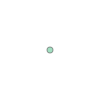

In [62]:
drone_point_2d = Point(lon, lat)
drone_point_2d

In [65]:
airspaces_in = gdf_airspace[gdf_airspace.contains(drone_point_2d)]
airspaces_in 

,airspace_name,geometry,min_altitude,max_altitude
365,WASHINGTON-TRI AREA CLASS B AREA E,"POLYGON Z ((-77.30330 39.15000 3048.00000, -77...",3048.0,3048.0
3235,WASHINGTON DC SFRA ADIZ,"POLYGON Z ((-77.03640 39.35910 5486.10000, -77...",5486.1,5486.1


In [52]:
gdf_airspace

,airspace_name,geometry,min_altitude,max_altitude
0,ATLANTA CLASS B AREA A,"POLYGON ((-84.49360 33.71640, -84.52810 33.716...",3810.0,3810.0
1,ATLANTA CLASS B AREA A,"POLYGON ((-84.54170 33.55390, -84.32830 33.553...",3810.0,3810.0
2,ATLANTA CLASS B AREA B,"POLYGON ((-84.53250 33.71310, -84.53500 33.713...",3810.0,3810.0
3,ATLANTA CLASS B AREA B,"POLYGON ((-84.52810 33.71640, -84.54890 33.716...",3810.0,3810.0
4,ATLANTA CLASS B AREA B,"POLYGON ((-84.21920 33.71640, -84.34220 33.716...",3810.0,3810.0
...,...,...,...,...
3235,WASHINGTON DC SFRA ADIZ,"POLYGON ((-77.03640 39.35910, -77.05670 39.358...",5486.1,5486.1
3236,WASHINGTON DC SFRA FRZ,"POLYGON ((-77.30830 38.99190, -77.31330 38.848...",5486.1,5486.1
3237,WASHINGTON DC SFRA LEESBURG MANEUVERING AREA B,"POLYGON ((-77.64060 39.02750, -77.55690 39.027...",457.2,457.2
3238,WASHINGTON DC SFRA LEESBURG MANEUVERING AREA C,"POLYGON ((-77.59190 39.10940, -77.58480 39.112...",762.0,762.0


In [99]:
gdf_airspace.to_file("airspaces.geojson", driver="GeoJSON")

In [77]:
gdf_airspace[gdf_airspace.contains(drone_point_2d)]

,airspace_name,geometry,min_altitude,max_altitude
569,NASHVILLE INTL AIRPORT CLASS C,"POLYGON Z ((-86.67830 36.20770 1402.08000, -86...",1402.08,1402.08


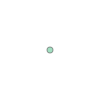

In [76]:
drone_point_2d = Point(longitude, latitude)
drone_point_2d

In [50]:
lat, lon

(36.00636604753713, -86.5329262275803)

In [56]:
drone_alt_m

1219.2

In [57]:
sample_string

"PRELIM INFO FROM FAA OPS: NASHVILLE, TN/UAS INCIDENT/1205C/\nNASHVILLE APCH ADVISED CESSNA C650, REPORTED A WHITE UAS FROM THE 10 O'CLOCK \nPOSITION WHILE NE BOUND AT 4,000 FEET 10 SE NASHVILLE. NO EVASIVE ACTION \nREPORTED. NASHVILLE ARPT PD NOTIFIED. WOC 7-3333 DJ/ER"

In [96]:
import re
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from geopy import Point as GeoPoint
from geopy.distance import distance
import geopandas as gpd
from zipfile import ZipFile
import xml.etree.ElementTree as ET
from fuzzywuzzy import process, fuzz

# === INPUT ===
sample_string = """PRELIM INFO FROM FAA OPS: NASHVILLE, TN/UAS INCIDENT/1205C/
NASHVILLE APCH ADVISED CESSNA C650, REPORTED A WHITE UAS FROM THE 10 O'CLOCK 
POSITION WHILE NE BOUND AT 4,000 FEET 10 SE NASHVILLE. NO EVASIVE ACTION 
REPORTED. NASHVILLE ARPT PD NOTIFIED. WOC 7-3333 DJ/ER"""

# === Load airport reference ===
with ZipFile("all-airport-data.xlsx.zip") as z:
    with z.open("all-airport-data.xlsx") as f:
        airport_codes_2 = pd.read_excel(f)

airport_trimmed = airport_codes_2.rename(columns={
    "Loc Id": "faa_code",
    "ARP Latitude DD": "latitude",
    "ARP Longitude DD": "longitude",
    "Name": "Facility Name"
}).dropna(subset=["latitude", "longitude"])

# === Extract Facility Name & Match ===
def extract_facility(summary):
    match = re.search(r'([A-Z\s]+)\s+(TRACON|ATCT|ARTCC|APCH|TWR)\s+ADVISED', summary.upper())
    return match.group(1).strip() if match else None

facility = extract_facility(sample_string)
matched_facility = process.extractOne(facility.title(), airport_trimmed["Facility Name"].dropna().unique().tolist(), scorer=fuzz.token_set_ratio)[0]
origin_row = airport_trimmed[airport_trimmed["Facility Name"] == matched_facility].iloc[0]
latitude, longitude = origin_row["latitude"], origin_row["longitude"]

# === Extract & Clean Location ===
def extract_location(summary):
    match = re.search(r'([0-9]+(?:\.\d+)?)\s+(N|NE|E|SE|S|SW|W|NW)\b', summary.upper())
    return f"{match.group(1)} {match.group(2)}" if match else None

location_cleaned = extract_location(sample_string)

# === Extract Altitude ===
def extract_altitude(summary):
    match = re.search(r'([0-9,]+)\s+FEET', summary.upper())
    return int(match.group(1).replace(",", "")) if match else np.nan

altitude = extract_altitude(sample_string)

# === Compute 3D Coordinates ===
DIRECTION_TO_BEARING = {"N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5, "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
                        "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5, "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5}

def compute_3d_coordinates(loc_cleaned, lat, lon, alt):
    try:
        dist_nm, direction = loc_cleaned.split()
        bearing = DIRECTION_TO_BEARING.get(direction.upper())
        dist_km = float(dist_nm) * 1.852
        origin = GeoPoint(lat, lon)
        dest = distance(kilometers=dist_km).destination(origin, bearing)
        return dest.latitude, dest.longitude, alt
    except:
        return np.nan, np.nan, np.nan

final_lat, final_lon, final_alt = compute_3d_coordinates(location_cleaned, latitude, longitude, altitude)

# === Parse KMZ into gdf_airspace ===
with ZipFile("united_states.kmz", 'r') as kmz:
    kml_filename = [name for name in kmz.namelist() if name.endswith('.kml')][0]
    with kmz.open(kml_filename) as kml_file:
        kml_content = kml_file.read()

root = ET.fromstring(kml_content)
ns = {'kml': 'http://www.opengis.net/kml/2.2'}
polygon_data = []

for placemark in root.findall(".//kml:Placemark", ns):
    name_tag = placemark.find("kml:name", ns)
    coords_tag = placemark.find(".//kml:coordinates", ns)
    if coords_tag is None:
        continue
    coords = [tuple(map(float, c.split(",")[:2])) for c in coords_tag.text.strip().split()]
    altitudes = [float(c.split(",")[2]) if len(c.split(",")) > 2 else 0.0 for c in coords_tag.text.strip().split()]
    if len(coords) > 2:
        polygon_data.append({
            "airspace_name": name_tag.text if name_tag is not None else None,
            "geometry": Polygon(coords),
            "min_altitude": min(altitudes),
            "max_altitude": max(altitudes)
        })

gdf_airspace = gpd.GeoDataFrame(polygon_data, crs='EPSG:4326')

# === Spatial Filter ===
drone_point_2d = Point(final_lon, final_lat)
dr_alt_m = final_alt * 0.3048
intersecting = gdf_airspace[
    (gdf_airspace.geometry.contains(drone_point_2d))
]

# === Result ===
print("✅ Not in controlled airspace" if intersecting.empty else intersecting[["airspace_name", "min_altitude", "max_altitude"]])

/Users/vishalivallioor/anaconda3/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                       airspace_name  min_altitude  max_altitude
570   NASHVILLE INTL AIRPORT CLASS C       1402.08       1402.08
1204                  SMYRNA CLASS D        762.00        762.00
